In [2]:
import numpy as np
import libpysal as ps
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
import geopandas as gp
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import scipy.stats as stats 

In [16]:
'''
Geographic Weighted Regression Model for Leukemia in Floria Counties applying pysal GWR libraries
Dependent Variable: Leukemia Incidence per 100,000 people
Independent Variables:
obs_pct : percent of population that is obese 2019 FL Health Survey
Percent_sm: percent of adult populations who are smokers 2019 FL Health Survey
PCT_ATRISK: Percent of populations between 0-15 and 65+
pesticide_: Percent of land cover per county with probable pesticide use
hydro_pct: Percent of land cover per county of hydrocarbon and other power infrastructure
uploading to github for convenient jupyter notebook output support
'''
fl_counties = gp.read_file('E:\\fl_leuk\\leukemia_fl.shp')
fl_counties = fl_counties.loc[fl_counties['INCIDENCE_'] > 0].copy()
fl_counties = fl_counties.loc[fl_counties['FIPS'] != '125'].copy()

fl_y = fl_counties['INCIDENCE_'].values.reshape((-1,1)) #leukemia incidence per 100,000
fl_x = fl_counties[["obs_pct", "Percent_sm", "PCT_ATRISK", "pesticide_", "hydro_pct"]].values 

coord_x = fl_counties['cen_x']
coord_y = fl_counties['cen_y']
centroid_coords = list(zip(coord_x,coord_y))
#normalize independent variables
fl_x = (fl_x - fl_x.mean(axis=0)) / fl_x.std(axis=0)
fl_y = fl_y.reshape((-1,1))
fl_y = (fl_y- fl_y.mean(axis=0)) / fl_y.std(axis=0)


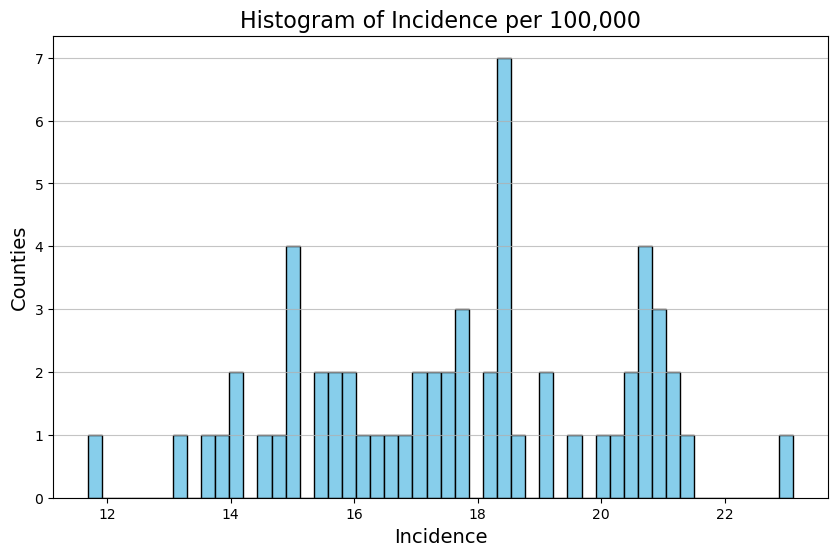

In [18]:
plt.figure(figsize=(10, 6))
plt.hist(fl_counties['INCIDENCE_'], bins=50, color='skyblue', edgecolor='black')
plt.title('Histogram of Incidence per 100,000', fontsize=16)
plt.xlabel('Incidence', fontsize=14)
plt.ylabel('Counties', fontsize=14)
plt.grid(axis='y', alpha=0.75)
plt.show()

In [19]:
gwr_selector = Sel_BW(centroid_coords, fl_y, fl_x)
gwr_bw = gwr_selector.search(multi_bw_min=[2])
print(gwr_bw)
gwr_results = GWR(centroid_coords, fl_y, fl_x, gwr_bw).fit()

58.0


In [20]:
np.float = float #fix for deprecated numpy float issue
'''gwr results with all 5 variables'''
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                  59
Number of covariates:                                                     6

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                             41.260
Log-likelihood:                                                     -73.167
AIC:                                                                158.334
AICc:                                                               162.530
BIC:                                                               -174.849
R2:                                                                   0.301
Adj. R2:                                                              0.235

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

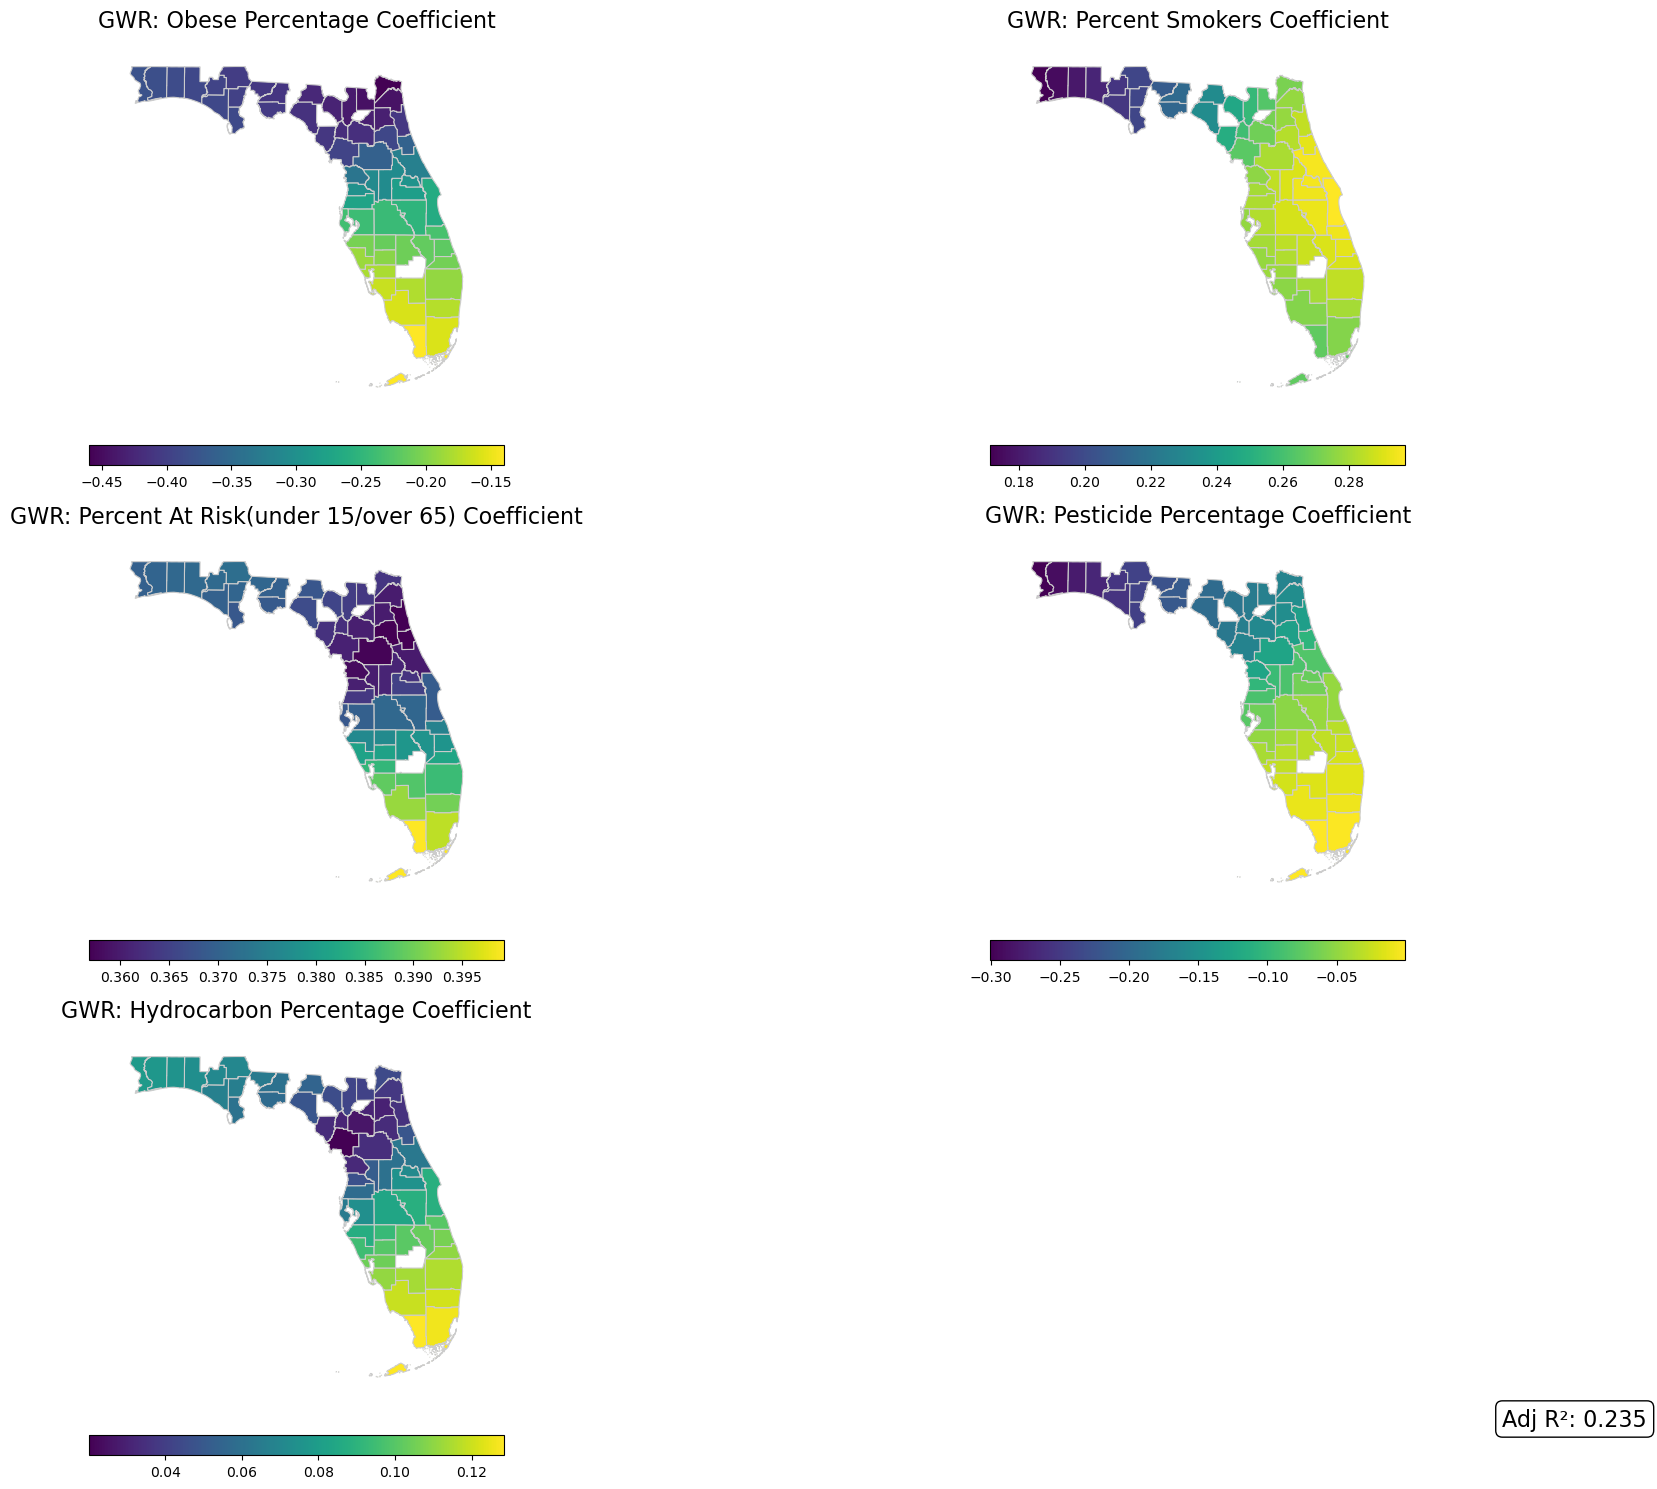

<Figure size 640x480 with 0 Axes>

In [23]:
# Coefficients
fl_counties['co_intercept'] = gwr_results.params[:, 0]
fl_counties['co_obs_pct'] = gwr_results.params[:, 1]
fl_counties['co_percent_smokers'] = gwr_results.params[:, 2]
fl_counties['co_pct_atrisk'] = gwr_results.params[:, 3]
fl_counties['co_pesticide_pct'] = gwr_results.params[:, 4]
fl_counties['co_hydro_pct'] = gwr_results.params[:, 5]
fl_counties['residuals'] = gwr_results.std_res
fl_counties['local_r2'] = gwr_results.localR2

variables = [
    ('co_obs_pct', 'GWR: Obese Percentage Coefficient'),                          #X1
    ('co_percent_smokers', 'GWR: Percent Smokers Coefficient'),                   #X2
    ('co_pct_atrisk', 'GWR: Percent At Risk(under 15/over 65) Coefficient'),      #X3
    ('co_pesticide_pct', 'GWR: Pesticide Percentage Coefficient'),                #X4 
    ('co_hydro_pct', 'GWR: Hydrocarbon Percentage Coefficient')                   #X5
]
num_vars = len(variables)
num_cols = 2
num_rows = (num_vars + 1) // 2  # Ceiling division to ensure enough rows
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, 5*num_rows))
axes = axes.flatten()

for i, (col, title) in enumerate(variables):
    ax = axes[i]
    ax.set_title(title, fontsize=16)
    cmap = plt.cm.viridis
    vmin = fl_counties[col].min()
    vmax = fl_counties[col].max()
    fl_counties.plot(column=col, cmap=cmap, linewidth=0.8, ax=ax, edgecolor='0.8', vmin=vmin, vmax=vmax)
    ax.set_axis_off()
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    fig.colorbar(sm, ax=ax, orientation='horizontal', fraction=0.05, pad=0.1)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])
fig.text(0.95, 0.05, 'Adj R²: 0.235', fontsize=16, ha='right', va='center', bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))

plt.tight_layout()
plt.show()
plt.tight_layout()
plt.show()

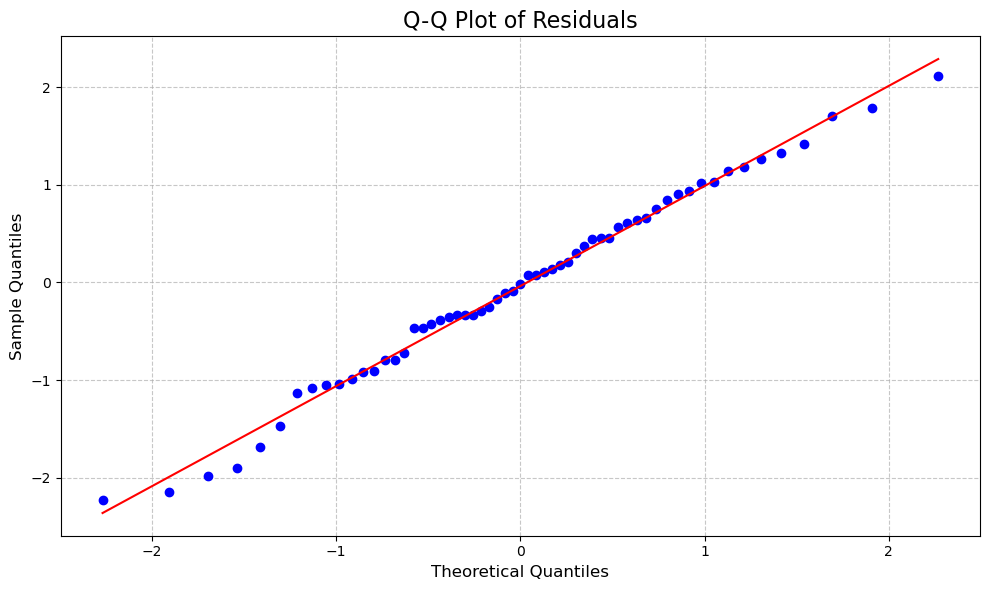

In [22]:
residuals = fl_counties['residuals']
# Create Q-Q Plot
plt.figure(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals', fontsize=16)
plt.xlabel('Theoretical Quantiles', fontsize=12)
plt.ylabel('Sample Quantiles', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

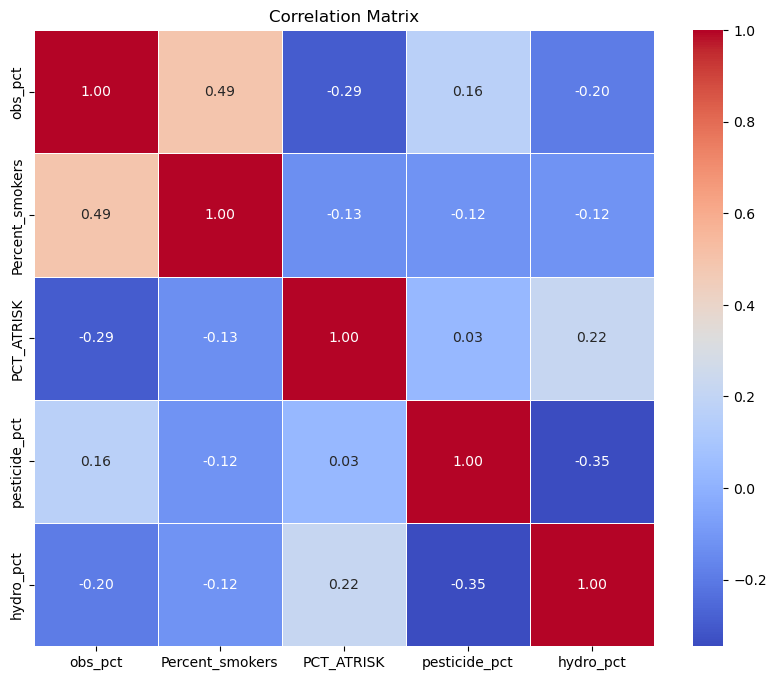

In [25]:
import seaborn as sns
independent_vars = pd.DataFrame(fl_x, columns=["obs_pct", "Percent_smokers", "PCT_ATRISK", "pesticide_pct", "hydro_pct"])
corr_matrix = independent_vars.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()